In [10]:
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt


In [21]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [22]:
# Function to encode clinical descriptions (query or features)
def encode_text(texts):
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=512)
    with torch.no_grad():
        outputs = model(**encoded_input)
    return outputs.last_hidden_state.mean(dim=1).numpy()


In [23]:

# Function to decompose query q into clinical features f1, f2, ..., fn
def decompose_query(query):
    # In a real scenario, this might require a more sophisticated NLP model to extract features.
    return query.split(",")  

In [32]:
# Calculate the similarity between clinical features and nodes in Knowledge Graph (KG)
def clinical_features_matching(features, knowledge_graph_nodes):
    # Convert features and KG nodes to embeddings
    feature_embeddings = encode_text(features)
    kg_embeddings = encode_text(knowledge_graph_nodes)
    
    # Compute the semantic similarity between each feature and each KG node using cosine similarity
    similarities = cosine_similarity(feature_embeddings, kg_embeddings)
    return similarities


In [25]:
# Step 4: Apply the indicator function to filter out irrelevant matches
def apply_indicator_function(similarities, threshold=0.7):
    # Filter the similarities based on the threshold
    valid_matches = (similarities > threshold).astype(int)
    return valid_matches

In [26]:
# Step 5: Retrieve the top-m most relevant matches (m closest matches)
def retrieve_top_matches(similarities, m=3):
    # For each feature, retrieve the top-m closest nodes from KG
    top_matches = []
    for i in range(similarities.shape[0]):
        sorted_indices = np.argsort(similarities[i])[::-1]  # Sort by similarity in descending order
        top_m = sorted_indices[:m]
        top_matches.append(top_m)
    return top_matches

In [27]:
# Step 6: Main function to match the query with the most relevant clinical feature nodes in the KG
def match_query_to_kg(query, knowledge_graph_nodes, threshold=0.7, top_m=3):
    # Decompose the query into features
    features = decompose_query(query)
    
    # Compute the similarity matrix between features and knowledge graph nodes
    similarities = clinical_features_matching(features, knowledge_graph_nodes, model)
    
    # Apply the indicator function to filter out irrelevant matches
    valid_matches = apply_indicator_function(similarities, threshold)
    
    # Retrieve the top-m most relevant matches from the knowledge graph
    top_matches = retrieve_top_matches(similarities * valid_matches, m=top_m)
    
    return top_matches

# Example query (patient's manifestation description)
query = "shortness of breath, cough, wheezing"

# Example knowledge graph nodes (clinical features in the KG)
knowledge_graph_nodes = [
    "asthma", "chronic bronchitis", "pneumonia", "copd", "heart failure", 
    "gastroesophageal reflux disease", "pulmonary embolism", "allergic rhinitis"
]

In [28]:
# Step 7: Retrieve the top-m most relevant clinical features
top_matches = match_query_to_kg(query, knowledge_graph_nodes, threshold=0.7, top_m=3)

# Output the results
print("Top matching clinical features in the knowledge graph:")
for match in top_matches:
    print(match)


Top matching clinical features in the knowledge graph:
[7 6 5]
[2 7 6]
[7 6 5]


In [29]:
def visualize_matching_graph(query, knowledge_graph_nodes, threshold=0.7, top_m=3):
    features = decompose_query(query)
    
    # Compute the similarity matrix between features and knowledge graph nodes
    similarities = clinical_features_matching(features, knowledge_graph_nodes)
    
    # Apply the indicator function to filter out irrelevant matches
    valid_matches = apply_indicator_function(similarities, threshold)
    
    # Retrieve the top-m most relevant matches from the knowledge graph
    top_matches = retrieve_top_matches(similarities * valid_matches, m=top_m)

    # Create a graph
    G = nx.Graph()
    
    # Add nodes for each feature and knowledge graph node
    for feature in features:
        G.add_node(feature, type='feature')
    for node in knowledge_graph_nodes:
        G.add_node(node, type='kg_node')

    # Add edges based on top matches
    for i, feature in enumerate(features):
        for j in top_matches[i]:
            G.add_edge(feature, knowledge_graph_nodes[j], weight=similarities[i][j])

    # Draw the graph
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    
    plt.figure(figsize=(12, 12))
    node_colors = ['skyblue' if G.nodes[node]['type'] == 'feature' else 'orange' for node in G.nodes]
    edge_weights = [G[u][v]['weight'] for u, v in G.edges]
    
    nx.draw_networkx_nodes(G, pos, node_size=3000, node_color=node_colors)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.5)
    plt.title("Clinical Features Matching Graph")
    plt.show()

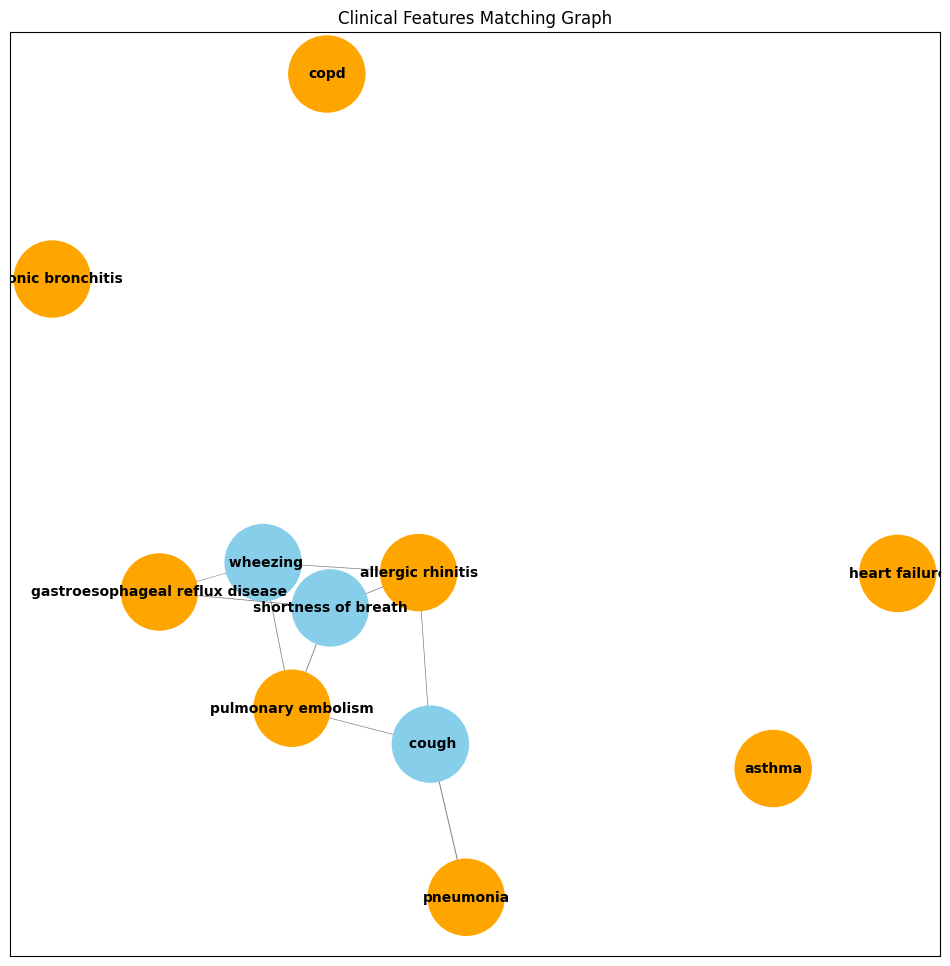

In [33]:
# Example query (patient's manifestation description)
query = "shortness of breath, cough, wheezing"

knowledge_graph_nodes = [
    "asthma", "chronic bronchitis", "pneumonia", "copd", "heart failure", 
    "gastroesophageal reflux disease", "pulmonary embolism", "allergic rhinitis"
]

# Visualize the matching graph
visualize_matching_graph(query, knowledge_graph_nodes, threshold=0.7, top_m=3)